### necessary modules

In [1]:
import numpy as np; 
import matplotlib.pyplot as plt; 
from scipy.stats import wilcoxon; 

# nwb related
from pynwb import NWBHDF5IO                        # to read/write
from pynwb import NWBFile                          # to set up
from pynwb.ecephys import LFP, ElectricalSeries    # to add raw data
from pynwb.file import Subject

# datetime related
from datetime import datetime
from dateutil import tz



### pre-processed files

In [56]:
files = ["/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P02/P02_M140_combined_13-14/processed/M140_230718_TextureFlow_LE_NPX_g2_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P02/P02_M140_combined_13-14/processed/M140_230718_TextureFlow_RE_NPX_g2_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P03/P03_M140_combined_09-14/processed/M140_230718_TextureFlow_LE_g3_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P03/P03_M140_combined_09-14/processed/M140_230718_TextureFlow_RE_g3_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P07/P07_M140_combined_07-11/processed/M140_230718_TextureFlow_LE_NPX_g7_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P07/P07_M140_combined_07-11/processed/M140_230718_TextureFlow_RE_NPX_g7_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P08/P08_M140_combined_06-12/processed/M140_230718_TextureFlow_LE_NPX_g8_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P08/P08_M140_combined_06-12/processed/M140_230719_TextureFlow_RE_NPX_g8_t1.npz",
         "/Volumes/TK_exHDD3/Anesthetized_V2_Jul2023/P11/07_M140_230719_TextureFlow_NPX_RE_g1/M140_230719_TextureFlow_NPX_RE_g1_imec0/processed/M140_230719_TextureFlow_NPX_RE_g1_t1.npz"
]


### Set up a NWB file

In [57]:
nwb_filename = '/Users/taekjunkim/Documents/UW_PasupathyLab/Experiments/5.AnesthetizedExp/July2023/' + 'TexFlow_DB.nwb'

# General info
nwbfile = NWBFile(
    session_description="combined data from anesthetized V2 experiment. July 2023",  # required
    identifier='TexFlow_V2_July2023',  # required
    session_start_time=datetime(2023, 7, 17, 10, 30, 0, tzinfo=tz.gettz('US/Pacific')),  # required
    experimenter="Kim, Taekjun",  # optional
    lab="Pasupathy Laboratory",  # optional
    institution="University of Washington",  # optional
    experiment_description="V2 responses to Texture flow (expanding or contracting)",  # optional
    session_id="TexFlow_V2_July2023",  # optional
)

# Subject info
nwbfile.subject = Subject(
    subject_id='M140',
    age='P1Y/P10Y', 
    description='Monkey 140',
    species='Cynomolgus', 
    sex='M'
)

# Electrode info
device = nwbfile.create_device(
    name='Neuropixels', 
    description="bank0_384ch", 
    manufacturer="IMEC"
)
nwbfile.add_electrode_column(name="label", description="label of electrode")

nprobes = 1
locations = ['V2']; 
nchannels_per_probe = 384

electrode_counter = 0
for iprobe in range(nprobes):

    electrode_group = nwbfile.create_electrode_group(
        name = "probe{}".format(iprobe),
        description = "electrode group for probe {}".format(iprobe),
        device = device,
        location = locations[iprobe],
    )

    for ielec in range(nchannels_per_probe):
        nwbfile.add_electrode(
            group = electrode_group,
            label = "probe{}elec{}".format(iprobe, ielec),
            location = locations[iprobe],
        )
        electrode_counter += 1

# Trial info
nwbfile.add_trial_column(
    name="session", description="session ID")
nwbfile.add_trial_column(
    name="condNum", description="condition number in the experiment")
nwbfile.add_trial_column(
    name="stimID", description="stim id")
nwbfile.add_trial_column(
    name="expand_contract", description="0: expand. 1: contract")
nwbfile.add_trial_column(
    name="pdOnTS", description="photodiode ON time",index=True)
nwbfile.add_trial_column(
    name="pdOffTS", description="photodiode OFF time",index=True)

# Unit info
nwbfile.add_unit_column(name="session", description="session ID")
nwbfile.add_unit_column(name="unitID", description="unitID in session")
nwbfile.add_unit_column(name="is_sua", description="0: mua, 1: sua")
nwbfile.add_unit_column(name="location", description="brain area")
nwbfile.add_unit_column(name="psth", description="post-stimulus time histogram", index=True)

### Combine files

In [58]:
for f in range(len(files)):
    fNow = files[f]; 
    dNow = np.load(files[f],allow_pickle=True); 
    numNeurons = dNow['numNeurons']; 
    neuronid = dNow['neuronid']; 
    StimResp = dNow['StimResp']; 
    psth_mtx = dNow['psth_mtx']; 
    ids_sua = dNow['id_sua']; 
    print(f'session# {f}: file is ready'); 

    ### add condition info
    for t in range(80):
        nwbfile.add_trial(
            session = f"session_{f}",
            condNum = int(t),
            stimID = int(t//2), 
            expand_contract = int(t%2), 
            pdOnTS = np.array(StimResp[t]['pdOn']), 
            pdOffTS = np.array(StimResp[t]['pdOff']), 
            start_time = -0.3,
            stop_time = 1.3, 
        )
    print(f'session# {f}: condition info was added'); 

    ### add unit info
    for c in range(numNeurons):
        unitID = neuronid[c]; 
        if unitID in ids_sua:
            is_sua = 1; 
        else:
            is_sua = 0; 

        nwbfile.add_unit(
            session = f"session_{f}",        
            unitID = int(unitID),
            is_sua = int(is_sua), 
            location = 'V2',  
            psth = psth_mtx[:80,:,c],
        )
    print(f'session# {f}: unit info was added'); 

    del dNow, numNeurons, neuronid, StimResp, psth_mtx, ids_sua; 


session# 0: file is ready
session# 0: condition info was added
session# 0: unit info was added
session# 1: file is ready
session# 1: condition info was added
session# 1: unit info was added
session# 2: file is ready
session# 2: condition info was added
session# 2: unit info was added
session# 3: file is ready
session# 3: condition info was added
session# 3: unit info was added
session# 4: file is ready
session# 4: condition info was added
session# 4: unit info was added
session# 5: file is ready
session# 5: condition info was added
session# 5: unit info was added
session# 6: file is ready
session# 6: condition info was added
session# 6: unit info was added
session# 7: file is ready
session# 7: condition info was added
session# 7: unit info was added
session# 8: file is ready
session# 8: condition info was added
session# 8: unit info was added


### Write file

In [59]:
with NWBHDF5IO(nwb_filename, 'w') as io:
    io.write(nwbfile)

### Read file

In [2]:
nwb_filename = '/Users/taekjunkim/Documents/UW_PasupathyLab/Experiments/5.AnesthetizedExp/July2023/' + 'TexFlow_DB.nwb'
with NWBHDF5IO(nwb_filename, 'r') as io:
    nwbfile = io.read(); 
    units = nwbfile.units.to_dataframe(); 
    trials = nwbfile.trials.to_dataframe(); 

In [11]:
pA_all = []; 
pB_all = []; 
yMax_all = []; 

for i in range(len(units)):
    expand_psth = units['psth'][i][np.arange(0,80,2),:]; 
    contract_psth = units['psth'][i][np.arange(1,80,2),:]; 

    expand_respA = np.mean(expand_psth[:,np.arange(400,800)],axis=1); 
    contract_respA = np.mean(contract_psth[:,np.arange(400,800)],axis=1);
    try:
        _, pA = wilcoxon(expand_respA,contract_respA); 
        pA_all.append(pA); 
    except:
        pA_all.append(1); 

    expand_respB = np.mean(expand_psth[:,np.arange(800,1200)],axis=1); 
    contract_respB = np.mean(contract_psth[:,np.arange(800,1200)],axis=1);
    try: 
        _, pB = wilcoxon(expand_respB,contract_respB); 
        pB_all.append(pB); 
    except:
        pB_all.append(1); 

    yMax_all.append(np.max([np.max(expand_psth), np.max(contract_psth)])); 

units['pA'] = pA_all; 
units['pB'] = pB_all; 
units['yMax'] = yMax_all; 

/Users/taekjunkim/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [12]:
units[(units['pA']<0.05)]


,session,unitID,is_sua,location,psth,pA,pB,yMax
id,,,,,,,,
6,session_0,25,1,V2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.043737e-03,4.208911e-01,43.246539
18,session_0,90,1,V2,"[[1.5820116921224439, 2.222643515090861, 3.000...",2.153552e-02,1.127227e-01,114.367276
24,session_0,107,1,V2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.129826e-03,9.206146e-02,43.453877
31,session_0,119,1,V2,"[[0.27217698613767966, 0.4487439864402464, 0.7...",1.241648e-02,1.107241e-02,66.082029
33,session_0,121,1,V2,"[[0.0, 0.0, 0.0, 0.0, 0.08880585113811997, 0.1...",3.258447e-02,2.944446e-01,98.262447
...,...,...,...,...,...,...,...,...
2752,session_8,50,1,V2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.569388e-08,3.569388e-08,67.587067
2760,session_8,112,1,V2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.025927e-02,3.387127e-01,21.020062
2800,session_8,41,0,V2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.669518e-02,7.580852e-01,15.215192


In [ ]:
unit_ids = np.where((units['pA']<0.05) & (units['pB']<0.05) & (units['yMax']>20))[0];
#unit_ids = np.where(((units['pA']<0.05) | (units['pB']<0.05)) & (units['yMax']>10))[0];

for i in unit_ids:
    unitID = units['unitID'][i]; 
    session = units['session'][i]; 

    expand_psth = units['psth'][i][np.arange(0,80,2),:]; 
    contract_psth = units['psth'][i][np.arange(1,80,2),:]; 
    yMax = units['yMax'][i]*0.6; 
    yMax3 = np.max([np.max(np.mean(expand_psth,axis=0)), 
                    np.max(np.mean(contract_psth,axis=0))]);     

    expand_respA = np.mean(expand_psth[:,np.arange(300,800)],axis=1); 
    contract_respA = np.mean(contract_psth[:,np.arange(300,800)],axis=1);

    #if np.mean(expand_respA)<np.mean(contract_respA):
    #    continue; 
    
    expand_resp = np.mean(expand_psth[:,np.arange(300+100,1200)],axis=1); 
    contract_resp = np.mean(contract_psth[:,np.arange(300+100,1200)],axis=1); 
    yMax2 = np.max([np.max(expand_resp), np.max(contract_resp)]); 

    stim_rank = (expand_resp).argsort()[::-1]; 

    plt.figure(figsize=(10,5)); 
    plt.subplot(2,3,1); 
    plt.imshow(expand_psth[stim_rank,:],vmin=0,vmax=yMax,aspect='auto',cmap='binary'); 
    plt.xticks(np.arange(300,1800,500),np.arange(0,1500,500)); 
    plt.gca().spines[['right', 'top']].set_visible(False)     
    plt.xlabel('Time from stimulus onset (ms)')
    plt.title(f'{session} - unit#: {unitID}. Expanding'); 

    plt.subplot(2,3,2); 
    plt.imshow(contract_psth[stim_rank,:],vmin=0,vmax=yMax,aspect='auto',cmap='binary'); 
    plt.xticks(np.arange(300,1800,500),np.arange(0,1500,500)); 
    plt.gca().spines[['right', 'top']].set_visible(False)     
    plt.xlabel('Time from stimulus onset (ms)')
    plt.title(f'{session} - unit#: {unitID}. Contracting'); 

    """
    plt.subplot(2,3,3);     
    session_id = units['session'][i]; 
    plt.title({session_id})
    """

    plt.subplot(2,3,4); 
    plt.plot(np.mean(expand_psth, axis=0), label='expanding');
    plt.plot(np.mean(contract_psth, axis=0), label='contracting'); 
    plt.xticks(np.arange(300,1800,500),np.arange(0,1500,500)); 
    plt.fill_between(np.arange(400,1200),yMax3,color='r',alpha=0.25); 
    plt.xlabel('Time from stimulus onset (ms)'); 
    plt.gca().spines[['right', 'top']].set_visible(False)        
    plt.legend(); 

    plt.subplot(2,3,5); 
    plt.plot(expand_resp[stim_rank], label='expanding'); 
    plt.plot(contract_resp[stim_rank], label='contracting'); 
    #plt.plot(expand_resp, contract_resp,'k.'); 
    #plt.plot([0, yMax2],[0, yMax2],'r'); 
    plt.gca().spines[['right', 'top']].set_visible(False)        
    plt.xlabel('Texture preference'); 
    plt.ylabel('Response (Hz)'); 
    plt.legend(); 


    """
    plt.subplot(2,3,6); 
    plt.plot(np.mean(expand_psth, axis=0) - np.mean(contract_psth, axis=0),'g', label='difference');
    plt.xticks(np.arange(300,1800,500),np.arange(0,1500,500)); 
    plt.xlabel('Time from stimulus onset (ms)'); 
    plt.gca().spines[['right', 'top']].set_visible(False)        
    plt.legend(); 
    """

    plt.tight_layout(); 

    if (session=='session_1') and (unitID == 150):
        plt.savefig(f"V2_TexFlow_{session}: {unitID}.pdf"); 
    elif (session=='session_3') and (unitID == 233):
        plt.savefig(f"V2_TexFlow_{session}: {unitID}.pdf"); 


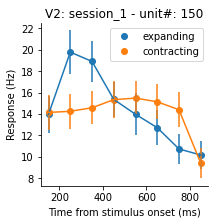

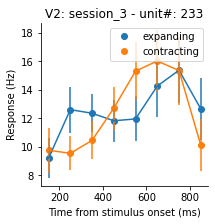

In [53]:
unit_ids = np.where(((units['session']=='session_1') & (units['unitID']==150))
                    | ((units['session']=='session_3') & (units['unitID']==233)))[0];

for i in unit_ids:
    unitID = units['unitID'][i]; 
    session = units['session'][i]; 

    expand_psth = units['psth'][i][np.arange(0,80,2),:]; 
    contract_psth = units['psth'][i][np.arange(1,80,2),:];

    expand_resp = np.mean(expand_psth[:,np.arange(300+100,1200)],axis=1); 
    stim_rank = (expand_resp).argsort()[::-1]; 

    ### time bins: 400~1200 (100 ms bins)
    binned_expand = [];    ## mean, ste at t_expand
    binned_contract = [];  ## mean, ste at t_contract
    for t in range(8):
        t_expand = np.arange(400+t*100,500+t*100); 
        t_contract = np.arange(1100-t*100,1200-t*100);

        expA = np.mean(np.mean(expand_psth[stim_rank][:,t_expand],axis=1),axis=0); 
        expB = np.std(np.mean(expand_psth[stim_rank][:,t_expand],axis=1),axis=0)/np.sqrt(len(stim_rank)); 
        binned_expand.append([expA, expB]); 

        conA = np.mean(np.mean(contract_psth[stim_rank][:,t_contract],axis=1),axis=0); 
        conB = np.std(np.mean(contract_psth[stim_rank][:,t_contract],axis=1),axis=0)/np.sqrt(len(stim_rank)); 
        binned_contract.append([conA, conB]); 

    binned_expand = np.array(binned_expand); 
    binned_contract = np.array(binned_contract);

    plt.figure(figsize=(3,3)); 
    #plt.subplot(1,2,1); 
    plt.plot(np.arange(150,950,100),binned_expand[:,0],'o',label='expanding'); 
    plt.plot(np.arange(150,950,100),binned_contract[:,0],'o',label='contracting'); 
    plt.errorbar(np.arange(150,950,100),binned_expand[:,0],binned_expand[:,1],color='C0'); 
    plt.errorbar(np.arange(150,950,100),binned_contract[:,0],binned_contract[:,1],color='C1'); 
    plt.gca().spines[['right', 'top']].set_visible(False)        
    plt.xlabel('Time from stimulus onset (ms)'); 
    plt.ylabel('Response (Hz)'); 
    plt.legend(); 
    plt.title(f'V2: {session} - unit#: {unitID}'); 

    """
    plt.subplot(1,2,2); 
    plt.plot(binned_expand[:,0],binned_contract[:,0],'k.'); 
    plt.gca().spines[['right', 'top']].set_visible(False)        
    plt.xlabel('Response. Expanding'); 
    plt.ylabel('Response. Contracting'); 
    """

    plt.savefig(f'V2: {session} - unit#: {unitID} supp.pdf'); 

    """
    for tt in range(3):
        t_expand = np.arange(500+tt*200,700+tt*200); 
        t_contract = np.arange(900-tt*200,1100-tt*200); 

        plt.subplot(1,4,2+tt); 
        respA = np.mean(expand_psth[stim_rank][:,t_expand],axis=1); 
        respB = np.mean(contract_psth[stim_rank][:,t_contract],axis=1); 
        yMax = np.max([np.max(respA),np.max(respB)]); 
        plt.plot(respA, label='expanding');
        plt.plot(respB, label='contracting'); 
        plt.gca().spines[['right', 'top']].set_visible(False)        
        plt.xlabel('Texture preference'); 
        plt.ylabel('Response (Hz)');
        plt.title(f"Time: {tt*200+200}ms ~ {tt*200+400} ms"); 
    plt.tight_layout(); 
    """





In [45]:
t_expand


array([], dtype=int64)